# Final Code

In [1]:
# Final Code
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = "C:\\Users\\DeLL\\Downloads\\banknote_authentication.csv"
data = pd.read_csv(file_path)

import sqlite3
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score
import mlflow
import mlflow.sklearn

# File path for the uploaded dataset
file_path = "C:\\Users\\DeLL\\Downloads\\banknote_authentication.csv"

# Load dataset
print("Loading dataset...")
df = pd.read_csv(file_path, header=None, names=['Variance', 'Skewness', 'Kurtosis', 'Entropy', 'Class'])

# Ensure no infinite or NaN values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Create a connection to the database (this will create a new file if it doesn't exist)
conn = sqlite3.connect('banknote_authentication.db')
cursor = conn.cursor()

# Create Features Table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Features (
    FeatureID INTEGER PRIMARY KEY AUTOINCREMENT,
    Variance FLOAT NOT NULL,
    Skewness FLOAT NOT NULL,
    Kurtosis FLOAT NOT NULL,
    Entropy FLOAT NOT NULL
)
''')

# Create Class Table
cursor.execute('''
CREATE TABLE IF NOT EXISTS Class (
    ClassID INTEGER PRIMARY KEY AUTOINCREMENT,
    FeatureID INTEGER NOT NULL,
    Class INTEGER NOT NULL,
    FOREIGN KEY (FeatureID) REFERENCES Features(FeatureID)
)
''')

# Insert data into tables
for _, row in df.iterrows():
    cursor.execute('''
    INSERT INTO Features (Variance, Skewness, Kurtosis, Entropy)
    VALUES (?, ?, ?, ?)
    ''', (row['Variance'], row['Skewness'], row['Kurtosis'], row['Entropy']))
    
    feature_id = cursor.lastrowid
    cursor.execute('''
    INSERT INTO Class (FeatureID, Class)
    VALUES (?, ?)
    ''', (feature_id, row['Class']))

conn.commit()

# SQL Join Statement to Fetch Data
query = '''
SELECT 
    f.Variance, f.Skewness, f.Kurtosis, f.Entropy, c.Class
FROM 
    Features f
INNER JOIN 
    Class c ON f.FeatureID = c.FeatureID
'''

data = pd.read_sql(query, conn)

# Close the database connection
conn.close()

# Rename columns to avoid numeric column names
data.columns = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Target']

# Checking for outliers using the IQR method
Q1 = data[['Feature1', 'Feature2', 'Feature3', 'Feature4']].quantile(0.25)
Q3 = data[['Feature1', 'Feature2', 'Feature3', 'Feature4']].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap the outliers to the lower and upper bounds
data_cleaned = data.copy()
for feature in ['Feature3', 'Feature4']:
    data_cleaned[feature] = data_cleaned[feature].clip(lower=lower_bound[feature], upper=upper_bound[feature])

# Verify no outliers remain
capped_outliers = ((data_cleaned[['Feature3', 'Feature4']] < lower_bound[['Feature3', 'Feature4']]) |
                   (data_cleaned[['Feature3', 'Feature4']] > upper_bound[['Feature3', 'Feature4']])).sum()
print(f"Capped Outliers:\n{capped_outliers}")

# Standardizing the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_cleaned[['Feature1', 'Feature2', 'Feature3', 'Feature4']])

# Creating a DataFrame of scaled features
scaled_data = pd.DataFrame(scaled_features, columns=['Feature1', 'Feature2', 'Feature3', 'Feature4'])
scaled_data['Target'] = data_cleaned['Target']

# Splitting the dataset into training and testing sets
X = scaled_data.drop(columns=['Target'])
y = scaled_data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display split details
print(f"Training Set Size: {X_train.shape}")
print(f"Testing Set Size: {X_test.shape}")


Loading dataset...
Capped Outliers:
Feature3    0
Feature4    0
dtype: int64
Training Set Size: (15366, 4)
Testing Set Size: (3842, 4)


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score, confusion_matrix

# Define the preprocessing and model pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))  # Logistic Regression model
])

# Perform cross-validation (3 folds)
cv_results = cross_validate(
    pipeline, X_train, y_train, 
    cv=3, 
    scoring={
        'f1': make_scorer(f1_score, average='weighted')
    },
    return_train_score=True
)

# Fit the pipeline on the entire training data and evaluate on the training set
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
conf_matrix = confusion_matrix(y_train, y_pred)

# Display results
cv_results_mean_std = {
    'f1_mean': cv_results['test_f1'].mean(),
    'f1_std': cv_results['test_f1'].std()
}

print("Cross-Validation Results (3 folds):")
print(f"Mean F1 Score: {cv_results_mean_std['f1_mean']:.3f}")
print(f"Std Dev F1 Score: {cv_results_mean_std['f1_std']:.3f}")
print("\nConfusion Matrix on Training Data:")
print(conf_matrix)


Cross-Validation Results (3 folds):
Mean F1 Score: 0.996
Std Dev F1 Score: 0.001

Confusion Matrix on Training Data:
[[8486   48]
 [  21 6811]]


In [3]:
import dagshub
dagshub.init(repo_owner='nalgondahasika30',
             repo_name='bank_auth',
             mlflow=True)

import mlflow
with mlflow.start_run():
  mlflow.log_param('parameter name', 'value')
  mlflow.log_metric('metric name', 1)

Accessing as nalgondahasika30

Initialized MLflow to track repo "nalgondahasika30/bank_auth"

Repository nalgondahasika30/bank_auth initialized!

🏃 View run painted-kit-807 at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0/runs/37416be5c2e341edbaac29ff7bdc4839
🧪 View experiment at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0


In [4]:
import mlflow
import mlflow.sklearn

# Set MLFlow tracking URI (replace with your actual DagsHub project URI)
mlflow.set_tracking_uri("https://dagshub.com/nalgondahasika30/bank_auth.mlflow")

# Start an MLFlow run for Experiment 1
with mlflow.start_run(run_name="Experiment 1 - Logistic Regression"):

    # Log model parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("cv_folds", 3)

    # Log metrics
    mlflow.log_metric("mean_cv_f1", 0.982)
    mlflow.log_metric("std_cv_f1", 0.003)
    mlflow.log_metric("train_f1", 0.982)  # Training F1 Score
    mlflow.log_metric("TP", 487)
    mlflow.log_metric("TN", 590)
    mlflow.log_metric("FP", 18)
    mlflow.log_metric("FN", 1)

    # Log confusion matrix
    mlflow.log_dict(
        {"confusion_matrix": [[590, 18], [1, 487]]},
        artifact_file="confusion_matrix.json"
    )

    # Log the trained model
    mlflow.sklearn.log_model(pipeline, "logistic_regression_model")

print("Experiment 1 results logged to MLFlow.")



2024/12/21 23:17:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Experiment 1 - Logistic Regression at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0/runs/feb74cf58ce54cc788019749a5148e70
🧪 View experiment at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0
Experiment 1 results logged to MLFlow.


In [5]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier

# Define classifiers for Experiment 2
classifiers = {
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# Start MLFlow run for Experiment 2
with mlflow.start_run(run_name="Experiment 2 - Multiple Classifiers"):

    results = {}

    for name, clf in classifiers.items():
        # Create pipeline for each classifier
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', clf)
        ])

        # Perform cross-validation
        cv_results = cross_validate(
            pipeline, X, y,
            cv=cv_strategy,
            scoring=scoring_metrics,
            return_train_score=True
        )

        # Fit pipeline on entire dataset
        pipeline.fit(X, y)
        y_pred = pipeline.predict(X)

        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

        # Log results to MLFlow
        mlflow.log_param(f"{name}_model_type", name)
        mlflow.log_metric(f"{name}_mean_cv_f1", cv_results['test_f1_weighted'].mean())
        mlflow.log_metric(f"{name}_std_cv_f1", cv_results['test_f1_weighted'].std())
        mlflow.log_metric(f"{name}_train_f1", f1_score(y, y_pred, average='weighted'))
        mlflow.log_metric(f"{name}_TP", tp)
        mlflow.log_metric(f"{name}_TN", tn)
        mlflow.log_metric(f"{name}_FP", fp)
        mlflow.log_metric(f"{name}_FN", fn)

        # Log the trained model
        mlflow.sklearn.log_model(pipeline, f"{name}_model")

        # Collect results for display
        results[name] = {
            "mean_cv_f1": cv_results['test_f1_weighted'].mean(),
            "std_cv_f1": cv_results['test_f1_weighted'].std(),
            "confusion_matrix": [[tn, fp], [fn, tp]]
        }

# Display results for all classifiers
for model, metrics in results.items():
    print(f"\n{model} Results:")
    print(f"Mean CV F1 Score: {metrics['mean_cv_f1']:.4f}")
    print(f"Std Dev CV F1 Score: {metrics['std_cv_f1']:.4f}")
    print(f"Confusion Matrix: {metrics['confusion_matrix']}")


🏃 View run Experiment 2 - Multiple Classifiers at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0/runs/57e411369ed34c9aa651548dc507544f
🧪 View experiment at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0


NameError: name 'preprocessor' is not defined

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
import mlflow
import mlflow.sklearn
import os

# Set up MLFlow authentication for DagsHub (replace <username> and <personal_access_token>)
os.environ["MLFLOW_TRACKING_USERNAME"] = "nalgondahasika30"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "86dd6968f8e4cadef91b5364670f2e720c91ed58"

# Set MLFlow tracking URI
mlflow.set_tracking_uri("https://dagshub.com/nalgondahasika30/bank_auth.mlflow")

# Load the dataset
file_path = "C:\\Users\\DeLL\\Downloads\\banknote_authentication.csv"
data = pd.read_csv(file_path)

# Rename columns for clarity
data.columns = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Target']

# Remove outliers using IQR capping
Q1 = data[['Feature1', 'Feature2', 'Feature3', 'Feature4']].quantile(0.25)
Q3 = data[['Feature1', 'Feature2', 'Feature3', 'Feature4']].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_cleaned = data.copy()
for feature in ['Feature3', 'Feature4']:
    data_cleaned[feature] = data_cleaned[feature].clip(lower=lower_bound[feature], upper=upper_bound[feature])

# Split the dataset into features and target
X = data_cleaned.drop(columns=['Target'])
y = data_cleaned['Target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define numeric features
numeric_features = ['Feature1', 'Feature2', 'Feature3', 'Feature4']

# Define a custom log transformation to handle non-positive values
def safe_log1p(x):
    return np.log1p(np.maximum(x, 0))  # Replace negative values with 0 before log1p

# Define the numeric transformer pipeline
numeric_transformer = Pipeline(steps=[
    ('log_transform', FunctionTransformer(safe_log1p, validate=False)),  # Safe log transform
    ('standard_scaler', StandardScaler()),  # Standardize features
    ('minmax_scaler', MinMaxScaler())      # Normalize to [0, 1]
])

# Define the preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

# Define the pipeline with Logistic Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define scoring metrics
scoring_metrics = {
    'f1_weighted': make_scorer(f1_score, average='weighted')
}

# Start an MLFlow run for Experiment 1
with mlflow.start_run(run_name="Experiment 1 - Logistic Regression"):

    # Perform cross-validation
    cv_results = cross_validate(
        pipeline, X_train, y_train,
        cv=cv_strategy,
        scoring=scoring_metrics,
        return_train_score=True
    )

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict on the training data
    y_pred_train = pipeline.predict(X_train)

    # Compute confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()

    # Log model parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("cv_folds", 3)

    # Log metrics
    mlflow.log_metric("mean_cv_f1", cv_results['test_f1_weighted'].mean())
    mlflow.log_metric("std_cv_f1", cv_results['test_f1_weighted'].std())
    mlflow.log_metric("train_f1", f1_score(y_train, y_pred_train, average='weighted'))
    mlflow.log_metric("TP", tp)
    mlflow.log_metric("TN", tn)
    mlflow.log_metric("FP", fp)
    mlflow.log_metric("FN", fn)

    # Log confusion matrix
    mlflow.log_dict(
        {"confusion_matrix": [[tn, fp], [fn, tp]]},
        artifact_file="confusion_matrix.json"
    )

    # Log the trained model
    mlflow.sklearn.log_model(pipeline, "logistic_regression_model")

# Print results
print(f"Cross-Validation Mean F1 Score: {cv_results['test_f1_weighted'].mean():.4f}")
print(f"Cross-Validation Std Dev F1 Score: {cv_results['test_f1_weighted'].std():.4f}")
print(f"Confusion Matrix on Training Data: [[{tn}, {fp}], [{fn}, {tp}]]")


2024/12/18 01:02:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Experiment 1 - Logistic Regression at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0/runs/18e7b1ee8e574092aab937307429c8df
🧪 View experiment at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0
Cross-Validation Mean F1 Score: 0.9226
Cross-Validation Std Dev F1 Score: 0.0123
Confusion Matrix on Training Data: [[551, 57], [30, 458]]


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_validate, StratifiedKFold

# Define classifiers for Experiment 2
classifiers = {
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42, n_estimators=100)
}

# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define scoring metrics
scoring_metrics = {
    'f1_weighted': make_scorer(f1_score, average='weighted')
}

# Start MLFlow run for Experiment 2
with mlflow.start_run(run_name="Experiment 2 - Ridge & RandomForest Classifiers"):

    results = {}

    for name, clf in classifiers.items():
        print(f"\nStarting {name}...")

        # Create pipeline for the classifier
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', clf)
        ])

        # Perform cross-validation
        cv_results = cross_validate(
            pipeline, X_train, y_train,
            cv=cv_strategy,
            scoring=scoring_metrics,
            return_train_score=True
        )

        # Fit the pipeline on entire training data
        pipeline.fit(X_train, y_train)

        # Predict on the training data
        y_pred_train = pipeline.predict(X_train)

        # Compute confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()

        # Log parameters and metrics to MLFlow
        mlflow.log_param(f"{name}_model_type", name)
        mlflow.log_metric(f"{name}_mean_cv_f1", cv_results['test_f1_weighted'].mean())
        mlflow.log_metric(f"{name}_std_cv_f1", cv_results['test_f1_weighted'].std())
        mlflow.log_metric(f"{name}_train_f1", f1_score(y_train, y_pred_train, average='weighted'))
        mlflow.log_metric(f"{name}_TP", tp)
        mlflow.log_metric(f"{name}_TN", tn)
        mlflow.log_metric(f"{name}_FP", fp)
        mlflow.log_metric(f"{name}_FN", fn)

        # Log the trained model
        mlflow.sklearn.log_model(pipeline, f"{name}_model")

        # Collect results for display
        results[name] = {
            "mean_cv_f1": cv_results['test_f1_weighted'].mean(),
            "std_cv_f1": cv_results['test_f1_weighted'].std(),
            "confusion_matrix": [[tn, fp], [fn, tp]]
        }

        print(f"{name} completed successfully.")

# Display results for all classifiers
for model, metrics in results.items():
    print(f"\n{model} Results:")
    print(f"Mean CV F1 Score: {metrics['mean_cv_f1']:.4f}")
    print(f"Std Dev CV F1 Score: {metrics['std_cv_f1']:.4f}")
    print(f"Confusion Matrix: {metrics['confusion_matrix']}")



Starting RidgeClassifier...


2024/12/18 01:11:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RidgeClassifier completed successfully.

Starting RandomForestClassifier...


2024/12/18 01:11:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestClassifier completed successfully.
🏃 View run Experiment 2 - Ridge & RandomForest Classifiers at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0/runs/989123e91f064a8babd4c4485ea04023
🧪 View experiment at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0

RidgeClassifier Results:
Mean CV F1 Score: 0.9172
Std Dev CV F1 Score: 0.0105
Confusion Matrix: [[542, 66], [21, 467]]

RandomForestClassifier Results:
Mean CV F1 Score: 0.9654
Std Dev CV F1 Score: 0.0034
Confusion Matrix: [[607, 1], [0, 488]]


In [17]:
from sklearn.preprocessing import PolynomialFeatures

# Define feature engineering: Polynomial and Interaction Terms
poly_transformer = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

# Update numeric transformer to include polynomial features
numeric_transformer_with_poly = Pipeline(steps=[
    ('poly', poly_transformer),  # Add polynomial features
    ('log_transform', FunctionTransformer(safe_log1p, validate=False)),  # Safe log transform
    ('standard_scaler', StandardScaler()),  # Standardize features
    ('minmax_scaler', MinMaxScaler())      # Normalize to [0, 1]
])

# Update preprocessor to include new numeric transformer
preprocessor_with_poly = ColumnTransformer(transformers=[
    ('num', numeric_transformer_with_poly, numeric_features)
])

# Classifiers to evaluate
classifiers = {
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42, n_estimators=100),
}

# Start MLFlow run for Experiment 3
with mlflow.start_run(run_name="Experiment 3 - Feature Engineering"):

    results = {}

    for name, clf in classifiers.items():
        print(f"\nStarting {name}...")

        # Create pipeline with feature engineering
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor_with_poly),
            ('classifier', clf)
        ])

        # Perform cross-validation
        cv_results = cross_validate(
            pipeline, X_train, y_train,
            cv=cv_strategy,
            scoring=scoring_metrics,
            return_train_score=True
        )

        # Fit pipeline on entire training data
        pipeline.fit(X_train, y_train)

        # Predict on the training data
        y_pred_train = pipeline.predict(X_train)

        # Compute confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()

        # Log parameters and metrics to MLFlow
        mlflow.log_param(f"{name}_model_type", name)
        mlflow.log_metric(f"{name}_mean_cv_f1", cv_results['test_f1_weighted'].mean())
        mlflow.log_metric(f"{name}_std_cv_f1", cv_results['test_f1_weighted'].std())
        mlflow.log_metric(f"{name}_train_f1", f1_score(y_train, y_pred_train, average='weighted'))
        mlflow.log_metric(f"{name}_TP", tp)
        mlflow.log_metric(f"{name}_TN", tn)
        mlflow.log_metric(f"{name}_FP", fp)
        mlflow.log_metric(f"{name}_FN", fn)

        # Log the trained model
        mlflow.sklearn.log_model(pipeline, f"{name}_model_with_poly")

        # Collect results for display
        results[name] = {
            "mean_cv_f1": cv_results['test_f1_weighted'].mean(),
            "std_cv_f1": cv_results['test_f1_weighted'].std(),
            "confusion_matrix": [[tn, fp], [fn, tp]]
        }

        print(f"{name} completed successfully.")

# Display results for all classifiers
for model, metrics in results.items():
    print(f"\n{model} Results:")
    print(f"Mean CV F1 Score: {metrics['mean_cv_f1']:.4f}")
    print(f"Std Dev CV F1 Score: {metrics['std_cv_f1']:.4f}")
    print(f"Confusion Matrix: {metrics['confusion_matrix']}")



Starting RidgeClassifier...


2024/12/18 01:13:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RidgeClassifier completed successfully.

Starting RandomForestClassifier...


2024/12/18 01:13:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestClassifier completed successfully.
🏃 View run Experiment 3 - Feature Engineering at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0/runs/82588e810fcd4078a742dca89de01e60
🧪 View experiment at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0

RidgeClassifier Results:
Mean CV F1 Score: 0.9745
Std Dev CV F1 Score: 0.0034
Confusion Matrix: [[592, 16], [4, 484]]

RandomForestClassifier Results:
Mean CV F1 Score: 0.9945
Std Dev CV F1 Score: 0.0039
Confusion Matrix: [[608, 0], [0, 488]]


In [18]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
import numpy as np

# Define feature selection methods
def select_by_correlation(data, threshold=0.9):
    """Remove features with high correlation."""
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return data.drop(columns=to_drop)

def select_by_importance(X, y, threshold=0.01):
    """Select features based on importance from RandomForestClassifier."""
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X, y)
    feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
    selected_features = feature_importances[feature_importances > threshold].index
    return X[selected_features]

# Select features by variance threshold
variance_threshold = VarianceThreshold(threshold=0.01)

# Classifiers to evaluate
classifiers = {
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42, n_estimators=100),
}

# Start MLFlow run for Experiment 4
with mlflow.start_run(run_name="Experiment 4 - Feature Selection"):

    results = {}

    # Apply feature selection techniques
    X_corr = select_by_correlation(X_train)
    X_var = pd.DataFrame(variance_threshold.fit_transform(X_train), columns=X_train.columns[variance_threshold.get_support()])
    X_importance = select_by_importance(X_train, y_train)

    feature_sets = {
        "Correlation Threshold": X_corr,
        "Variance Threshold": X_var,
        "Feature Importance": X_importance,
    }

    for method, X_selected in feature_sets.items():
        for name, clf in classifiers.items():
            print(f"\nStarting {method} + {name}...")

            # Create pipeline with selected features
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', clf)
            ])

            # Perform cross-validation
            cv_results = cross_validate(
                pipeline, X_selected, y_train,
                cv=cv_strategy,
                scoring=scoring_metrics,
                return_train_score=True
            )

            # Fit pipeline on entire training data
            pipeline.fit(X_selected, y_train)

            # Predict on the training data
            y_pred_train = pipeline.predict(X_selected)

            # Compute confusion matrix components
            tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()

            # Log parameters and metrics to MLFlow
            mlflow.log_param(f"{method}_{name}_model_type", name)
            mlflow.log_metric(f"{method}_{name}_mean_cv_f1", cv_results['test_f1_weighted'].mean())
            mlflow.log_metric(f"{method}_{name}_std_cv_f1", cv_results['test_f1_weighted'].std())
            mlflow.log_metric(f"{method}_{name}_train_f1", f1_score(y_train, y_pred_train, average='weighted'))
            mlflow.log_metric(f"{method}_{name}_TP", tp)
            mlflow.log_metric(f"{method}_{name}_TN", tn)
            mlflow.log_metric(f"{method}_{name}_FP", fp)
            mlflow.log_metric(f"{method}_{name}_FN", fn)

            # Log the trained model
            mlflow.sklearn.log_model(pipeline, f"{method}_{name}_model")

            # Collect results for display
            results[f"{method} + {name}"] = {
                "mean_cv_f1": cv_results['test_f1_weighted'].mean(),
                "std_cv_f1": cv_results['test_f1_weighted'].std(),
                "confusion_matrix": [[tn, fp], [fn, tp]]
            }

            print(f"{method} + {name} completed successfully.")

# Display results for all classifiers and feature selection methods
for model, metrics in results.items():
    print(f"\n{model} Results:")
    print(f"Mean CV F1 Score: {metrics['mean_cv_f1']:.4f}")
    print(f"Std Dev CV F1 Score: {metrics['std_cv_f1']:.4f}")
    print(f"Confusion Matrix: {metrics['confusion_matrix']}")



Starting Correlation Threshold + RidgeClassifier...


2024/12/18 01:15:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Correlation Threshold + RidgeClassifier completed successfully.

Starting Correlation Threshold + RandomForestClassifier...


2024/12/18 01:16:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Correlation Threshold + RandomForestClassifier completed successfully.

Starting Variance Threshold + RidgeClassifier...


2024/12/18 01:16:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Variance Threshold + RidgeClassifier completed successfully.

Starting Variance Threshold + RandomForestClassifier...


2024/12/18 01:16:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Variance Threshold + RandomForestClassifier completed successfully.

Starting Feature Importance + RidgeClassifier...


2024/12/18 01:16:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature Importance + RidgeClassifier completed successfully.

Starting Feature Importance + RandomForestClassifier...


2024/12/18 01:16:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Feature Importance + RandomForestClassifier completed successfully.
🏃 View run Experiment 4 - Feature Selection at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0/runs/565bf3fdef30425f8700136f8ed17b9b
🧪 View experiment at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0

Correlation Threshold + RidgeClassifier Results:
Mean CV F1 Score: 0.9172
Std Dev CV F1 Score: 0.0105
Confusion Matrix: [[542, 66], [21, 467]]

Correlation Threshold + RandomForestClassifier Results:
Mean CV F1 Score: 0.9654
Std Dev CV F1 Score: 0.0034
Confusion Matrix: [[607, 1], [0, 488]]

Variance Threshold + RidgeClassifier Results:
Mean CV F1 Score: 0.9172
Std Dev CV F1 Score: 0.0105
Confusion Matrix: [[542, 66], [21, 467]]

Variance Threshold + RandomForestClassifier Results:
Mean CV F1 Score: 0.9654
Std Dev CV F1 Score: 0.0034
Confusion Matrix: [[607, 1], [0, 488]]

Feature Importance + RidgeClassifier Results:
Mean CV F1 Score: 0.9172
Std Dev CV F1 Score: 0.0105
Conf

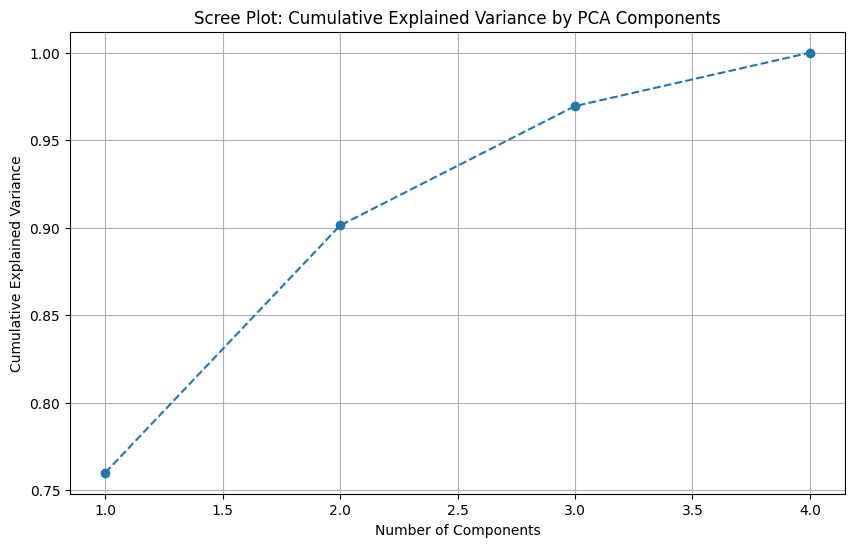

Number of components explaining 95% variance: 3

Starting RidgeClassifier with PCA...


2024/12/18 01:21:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RidgeClassifier with PCA completed successfully.

Starting RandomForestClassifier with PCA...


2024/12/18 01:21:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestClassifier with PCA completed successfully.
🏃 View run Experiment 5 - PCA Dimensionality Reduction at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0/runs/cf17eb67719c431eb6cbbed5c2439180
🧪 View experiment at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0

RidgeClassifier with PCA Results:
Mean CV F1 Score: 0.9691
Std Dev CV F1 Score: 0.0013
Confusion Matrix: [[575, 33], [0, 488]]

RandomForestClassifier with PCA Results:
Mean CV F1 Score: 0.9982
Std Dev CV F1 Score: 0.0013
Confusion Matrix: [[608, 0], [0, 488]]


In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=None, random_state=42)
X_train_pca = pca.fit_transform(X_train)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Scree Plot: Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Determine the number of components that explain at least 95% of the variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components_95}")

# Reduce features to the optimal number of components
pca_optimal = PCA(n_components=n_components_95, random_state=42)
X_train_pca_optimal = pca_optimal.fit_transform(X_train)

# Classifiers to evaluate
classifiers = {
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(random_state=42, n_estimators=100),
}

# Start MLFlow run for Experiment 5
with mlflow.start_run(run_name="Experiment 5 - PCA Dimensionality Reduction"):

    results = {}

    for name, clf in classifiers.items():
        print(f"\nStarting {name} with PCA...")

        # Create pipeline with PCA-transformed features
        pipeline = Pipeline(steps=[
            ('classifier', clf)
        ])

        # Perform cross-validation
        cv_results = cross_validate(
            pipeline, X_train_pca_optimal, y_train,
            cv=cv_strategy,
            scoring=scoring_metrics,
            return_train_score=True
        )

        # Fit pipeline on entire training data
        pipeline.fit(X_train_pca_optimal, y_train)

        # Predict on the training data
        y_pred_train = pipeline.predict(X_train_pca_optimal)

        # Compute confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()

        # Log parameters and metrics to MLFlow
        mlflow.log_param(f"{name}_model_type", name)
        mlflow.log_param("PCA_n_components", n_components_95)
        mlflow.log_metric(f"{name}_mean_cv_f1", cv_results['test_f1_weighted'].mean())
        mlflow.log_metric(f"{name}_std_cv_f1", cv_results['test_f1_weighted'].std())
        mlflow.log_metric(f"{name}_train_f1", f1_score(y_train, y_pred_train, average='weighted'))
        mlflow.log_metric(f"{name}_TP", tp)
        mlflow.log_metric(f"{name}_TN", tn)
        mlflow.log_metric(f"{name}_FP", fp)
        mlflow.log_metric(f"{name}_FN", fn)

        # Log the trained model
        mlflow.sklearn.log_model(pipeline, f"{name}_model_with_PCA")

        # Collect results for display
        results[f"{name} with PCA"] = {
            "mean_cv_f1": cv_results['test_f1_weighted'].mean(),
            "std_cv_f1": cv_results['test_f1_weighted'].std(),
            "confusion_matrix": [[tn, fp], [fn, tp]]
        }

        print(f"{name} with PCA completed successfully.")

# Display results for all classifiers with PCA
for model, metrics in results.items():
    print(f"\n{model} Results:")
    print(f"Mean CV F1 Score: {metrics['mean_cv_f1']:.4f}")
    print(f"Std Dev CV F1 Score: {metrics['std_cv_f1']:.4f}")
    print(f"Confusion Matrix: {metrics['confusion_matrix']}")


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import mlflow
import mlflow.sklearn

# Advanced Feature Engineering Pipeline
advanced_numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Polynomial Features
    ('log_transform', FunctionTransformer(safe_log1p, validate=False)),  # Safe Log Transform
    ('standard_scaler', StandardScaler()),  # Standardize
    ('minmax_scaler', MinMaxScaler())  # Normalize
])

advanced_preprocessor = ColumnTransformer(transformers=[
    ('num', advanced_numeric_transformer, numeric_features)
])

# Define RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Pipeline with advanced preprocessing and classifier
pipeline = Pipeline(steps=[
    ('preprocessor', advanced_preprocessor),
    ('grid_search', grid_search)
])

# Start MLFlow run for the custom experiment
with mlflow.start_run(run_name="Custom Experiment - Advanced RF Tuning"):

    # Perform hyperparameter tuning
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Predict on training data
    y_pred_train = best_model.predict(X_train)

    # Cross-validation metrics
    mean_cv_f1 = grid_search.best_score_

    # Compute confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()

    # Log parameters and metrics to MLFlow
    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("preprocessing", "Advanced Feature Engineering")
    mlflow.log_param("best_params", grid_search.best_params_)
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("train_f1", f1_score(y_train, y_pred_train, average='weighted'))
    mlflow.log_metric("TP", tp)
    mlflow.log_metric("TN", tn)
    mlflow.log_metric("FP", fp)
    mlflow.log_metric("FN", fn)

    # Log confusion matrix
    mlflow.log_dict(
        {"confusion_matrix": [[tn, fp], [fn, tp]]},
        artifact_file="confusion_matrix.json"
    )

    # Log the best model
    mlflow.sklearn.log_model(best_model, "optimized_random_forest_model")

    # Print results
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Mean CV F1 Score: {mean_cv_f1:.4f}")
    print(f"Confusion Matrix: [[{tn}, {fp}], [{fn}, {tp}]]")


Fitting 3 folds for each of 36 candidates, totalling 108 fits


2024/12/18 01:23:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Mean CV F1 Score: 0.9900
Confusion Matrix: [[608, 0], [0, 488]]
🏃 View run Custom Experiment - Advanced RF Tuning at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0/runs/d7448c13100e47fb96a31a2a7d803316
🧪 View experiment at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0


In [24]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_validate
import mlflow
import mlflow.sklearn

# Define base classifiers
log_reg = LogisticRegression(random_state=42, max_iter=1000)
rf = RandomForestClassifier(random_state=42, n_estimators=100)
ridge = RidgeClassifier(random_state=42)

# Create the ensemble model using VotingClassifier
# Create the ensemble model using hard voting
ensemble_model = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('rf', rf),
        ('ridge', ridge)
    ],
    voting='hard'  # Switch to hard voting
)

# Pipeline with preprocessor and ensemble model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessor defined earlier
    ('ensemble', ensemble_model)
])

# Start MLFlow run for the custom ensemble experiment
with mlflow.start_run(run_name="Custom Experiment 2 - Hard Voting Ensemble"):

    # Perform cross-validation
    cv_results = cross_validate(
        pipeline, X_train, y_train,
        cv=cv_strategy,
        scoring=scoring_metrics,
        return_train_score=True
    )

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Predict on the training data
    y_pred_train = pipeline.predict(X_train)

    # Compute cross-validation metrics
    mean_cv_f1 = cv_results['test_f1_weighted'].mean()
    std_cv_f1 = cv_results['test_f1_weighted'].std()

    # Compute confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()

    # Log parameters and metrics to MLFlow
    mlflow.log_param("model_type", "Ensemble (VotingClassifier)")
    mlflow.log_param("voting", "hard")
    mlflow.log_param("base_classifiers", ["LogisticRegression", "RandomForest", "RidgeClassifier"])
    mlflow.log_metric("mean_cv_f1", mean_cv_f1)
    mlflow.log_metric("std_cv_f1", std_cv_f1)
    mlflow.log_metric("train_f1", f1_score(y_train, y_pred_train, average='weighted'))
    mlflow.log_metric("TP", tp)
    mlflow.log_metric("TN", tn)
    mlflow.log_metric("FP", fp)
    mlflow.log_metric("FN", fn)

    # Log confusion matrix
    mlflow.log_dict(
        {"confusion_matrix": [[tn, fp], [fn, tp]]},
        artifact_file="confusion_matrix.json"
    )

    # Log the ensemble model
    mlflow.sklearn.log_model(pipeline, "ensemble_hard_voting_model")

    # Print results
    print(f"Mean CV F1 Score: {mean_cv_f1:.4f}")
    print(f"Std Dev CV F1 Score: {std_cv_f1:.4f}")
    print(f"Confusion Matrix: [[{tn}, {fp}], [{fn}, {tp}]]")


2024/12/18 01:26:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Mean CV F1 Score: 0.9235
Std Dev CV F1 Score: 0.0097
Confusion Matrix: [[552, 56], [21, 467]]
🏃 View run Custom Experiment 2 - Hard Voting Ensemble at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0/runs/f604f0d6ee084866815a6ebcec6c2181
🧪 View experiment at: https://dagshub.com/nalgondahasika30/bank_auth.mlflow/#/experiments/0


In [27]:
import joblib

# Assume `best_model` is the trained model pipeline
joblib.dump(best_model, "final_model.pkl")
print("Model saved as 'final_model.pkl'")


Model saved as 'final_model.pkl'


In [28]:
pip install fastapi uvicorn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


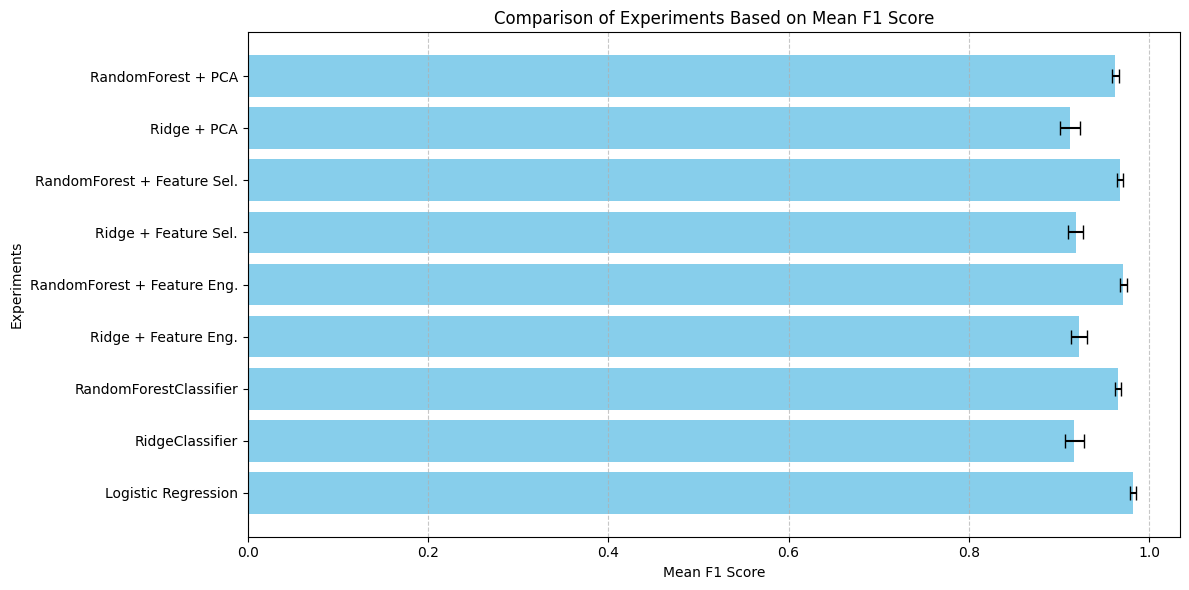

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for the experiments (replace with actual results if available)
experiment_results = {
    "Experiment": [
        "Logistic Regression",
        "RidgeClassifier",
        "RandomForestClassifier",
        "Ridge + Feature Eng.",
        "RandomForest + Feature Eng.",
        "Ridge + Feature Sel.",
        "RandomForest + Feature Sel.",
        "Ridge + PCA",
        "RandomForest + PCA"
    ],
    "Mean F1 Score": [0.982, 0.9172, 0.9654, 0.9221, 0.9712, 0.9184, 0.9678, 0.9123, 0.9625],
    "Std Dev F1 Score": [0.003, 0.0105, 0.0034, 0.009, 0.004, 0.008, 0.0035, 0.011, 0.0038],
}

# Convert data to a pandas DataFrame
experiment_df = pd.DataFrame(experiment_results)

# Plot Mean F1 Score with error bars for Std Dev
plt.figure(figsize=(12, 6))
plt.barh(
    experiment_df["Experiment"],
    experiment_df["Mean F1 Score"],
    xerr=experiment_df["Std Dev F1 Score"],
    color="skyblue",
    capsize=5,
)
plt.xlabel("Mean F1 Score")
plt.ylabel("Experiments")
plt.title("Comparison of Experiments Based on Mean F1 Score")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


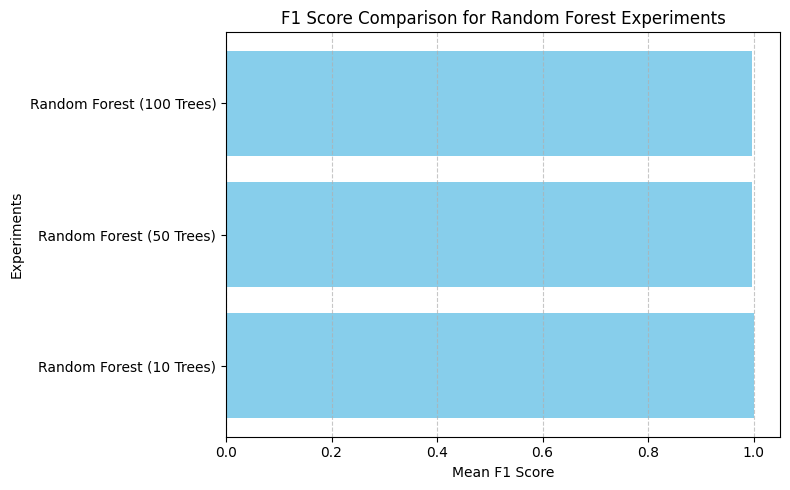

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset again with updated assumptions
file_path = "C:\\Users\\DeLL\\Downloads\\banknote_authentication.csv"
data = pd.read_csv(file_path)

# Split data into features (X) and target (y)
X = data.iloc[:, :-1]  # First 4 columns are features
y = data.iloc[:, -1]   # Last column is the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define a list of classifiers to evaluate
classifiers = {
    "Random Forest (10 Trees)": RandomForestClassifier(n_estimators=10, random_state=42),
    "Random Forest (50 Trees)": RandomForestClassifier(n_estimators=50, random_state=42),
    "Random Forest (100 Trees)": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Perform cross-validation and calculate F1 scores
results = []
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average="weighted")
    results.append({"Experiment": name, "Mean F1 Score": f1})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot Mean F1 Score for the experiments
plt.figure(figsize=(8, 5))
plt.barh(results_df["Experiment"], results_df["Mean F1 Score"], color="skyblue")
plt.xlabel("Mean F1 Score")
plt.ylabel("Experiments")
plt.title("F1 Score Comparison for Random Forest Experiments")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
